In [157]:
import logging 
import warnings
import pandas as pd
from tqdm import tqdm
from prophet import Prophet
from itertools import product
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from prophet.diagnostics import cross_validation,performance_metrics

logging.getLogger('fbprophet').setLevel(logging.ERROR)
warnings.filterwarnings(action='ignore')

In [36]:
data = pd.read_csv("../Datasets/wiki_views_2010010100_2022043000.csv",index_col=0)
data.shape

(2496, 1)

In [37]:
data.index = pd.DatetimeIndex(data.index,freq='D')

In [38]:
data.head()

,views
2015-07-01,264.542787
2015-07-02,270.340050
2015-07-03,253.265588
2015-07-04,253.088829
2015-07-05,266.057125


In [35]:
?cross_validation

Signature:
cross_validation(
    model,
    horizon,
    period=None,
    initial=None,
    parallel=None,
    cutoffs=None,
    disable_tqdm=False,
)
Docstring:
Cross-Validation for time series.

Computes forecasts from historical cutoff points, which user can input.
If not provided, begins from (end - horizon) and works backwards, making
cutoffs with a spacing of period until initial is reached.

When period is equal to the time interval of the data, this is the
technique described in https://robjhyndman.com/hyndsight/tscv/ .

Parameters
----------
model: Prophet class object. Fitted Prophet model.
horizon: string with pd.Timedelta compatible style, e.g., '5 days',
    '3 hours', '10 seconds'.
period: string with pd.Timedelta compatible style. Simulated forecast will
    be done at every this period. If not provided, 0.5 * horizon is used.
initial: string with pd.Timedelta compatible style. The first training
    period will include at least this much data. If not provided,
    3 * h

In [39]:
?performance_metrics

Signature: performance_metrics(df, metrics=None, rolling_window=0.1, monthly=False)
Docstring:
Compute performance metrics from cross-validation results.

Computes a suite of performance metrics on the output of cross-validation.
By default the following metrics are included:
'mse': mean squared error
'rmse': root mean squared error
'mae': mean absolute error
'mape': mean absolute percent error
'mdape': median absolute percent error
'smape': symmetric mean absolute percentage error
'coverage': coverage of the upper and lower intervals

A subset of these can be specified by passing a list of names as the
`metrics` argument.

Metrics are calculated over a rolling window of cross validation
predictions, after sorting by horizon. Averaging is first done within each
value of horizon, and then across horizons as needed to reach the window
size. The size of that window (number of simulated forecast points) is
determined by the rolling_window argument, which specifies a proportion of
simulated

In [78]:
param_grid = {  'growth': ["linear"], 
                'yearly_seasonality': ["auto"],
                'weekly_seasonality': ["auto"],
                'daily_seasonality': [False],
                'seasonality_mode': ["additive"],
                'seasonality_prior_scale': [10, 50],
                'changepoint_prior_scale': [0.1, 0.33, 0.66],
                'mcmc_samples': [0],
                'interval_width': [0.25, 0.5, 0.75],
                'uncertainty_samples': [0]
              }

args = list(product(*param_grid.values()))

In [98]:
train = data.iloc[0:1200][['views']].reset_index().rename(columns={"index":'ds','views':'y'})
test = data.iloc[1200:][['views']].reset_index().rename(columns={"index":'ds','views':'y'})

df_ps = pd.DataFrame()

for arg in tqdm(args):
    kwargs = dict(zip(param_grid.keys(),arg))
    m = Prophet(**kwargs).fit(train)
    df_cv = cross_validation(m, initial='1000 days', period='21 days', horizon = '21 days')
    df_p = performance_metrics(df_cv, rolling_window=1)
    df_p['params'] = str(arg)
    df_ps = df_ps.append(df_p)

df_ps['mae+rmse'] = df_ps['mae']+df_ps['rmse']
df_ps = df_ps.sort_values(['mae+rmse'])

  0%|          | 0/18 [00:00<?, ?it/s]INFO:prophet:Making 9 forecasts with cutoffs between 2018-04-06 00:00:00 and 2018-09-21 00:00:00










  6%|▌         | 1/18 [00:30<08:44, 30.86s/it]INFO:prophet:Making 9 forecasts with cutoffs between 2018-04-06 00:00:00 and 2018-09-21 00:00:00










 11%|█         | 2/18 [01:00<08:05, 30.35s/it]INFO:prophet:Making 9 forecasts with cutoffs between 2018-04-06 00:00:00 and 2018-09-21 00:00:00










 17%|█▋        | 3/18 [01:30<07:30, 30.06s/it]INFO:prophet:Making 9 forecasts with cutoffs between 2018-04-06 00:00:00 and 2018-09-21 00:00:00










 22%|██▏       | 4/18 [02:23<09:04, 38.92s/it]INFO:prophet:Making 9 forecasts with cutoffs between 2018-04-06 00:00:00 and 2018-09-21 00:00:00










 28%|██▊       | 5/18 [03:15<09:30, 43.92s/it]INFO:prophet:Making 9 forecasts with cutoffs between 2018-04-06 00:00:00 and 2018-09-21 00:00:00










 33%|███▎      | 6/18 [04:08<09:22, 46.91s/it]INFO:prophet:Making 9 forecasts with cutoffs

In [102]:
df_ps.params.values[0]

"('linear', 'auto', 'auto', False, 'additive', 50, 0.1, 0, 0.25, 0)"

In [104]:
parameters = {'growth': 'linear',
 'yearly_seasonality': 'auto',
 'weekly_seasonality': 'auto',
 'daily_seasonality': False,
 'seasonality_mode': 'additive',
 'seasonality_prior_scale': 50,
 'changepoint_prior_scale': 0.1,
 'mcmc_samples': 0,
 'interval_width': 0.25,
 'uncertainty_samples': 0}

In [150]:
train = data.iloc[0:2475][['views']].reset_index().rename(columns={"index":'ds','views':'y'})
test = data.iloc[2475:][['views']].reset_index().rename(columns={"index":'ds','views':'y'})

m = Prophet(**parameters).fit(train)

In [151]:
predictions = m.predict(test)

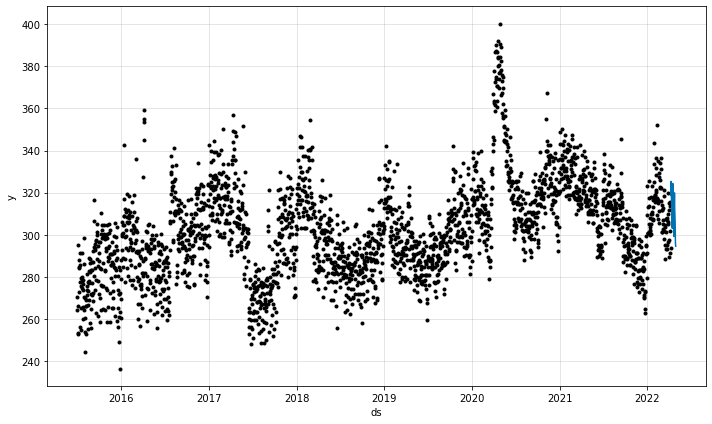

In [152]:
m.plot(predictions)
plt.show()

In [153]:
def plot_predictions(observed,predicted):

    error = "{0:.3f}%".format(MAPE(observed,predicted)*100)

    plt.figure(figsize=(15,7))
    plt.plot(observed,color='black',label='oberved')
    plt.plot(predicted,color='#FF3B2B',label='predicted')
    plt.legend(loc='upper center')
    plt.xlabel("Date",fontfamily='serif')
    plt.ylabel("Views (Mn)",fontfamily='serif')
    plt.title(f"Predictions vs Observed\nMAPE={error}", fontsize=18,fontweight='semibold',fontfamily='serif')
    plt.grid(True)
    plt.show()

In [154]:
predictions.set_index('ds',inplace=True)
predictions.index.name = None
predictions = predictions[['yhat']]
predictions.head()

,yhat
2022-04-10,318.745990
2022-04-11,325.308580
2022-04-12,318.591674
2022-04-13,315.854747
2022-04-14,312.451883


In [155]:
predictions.rename(columns={"yhat":'views'},inplace=True)
test.rename(columns={"yhat":'views'},inplace=True)
test.set_index('ds',inplace=True)
test.index.name = None

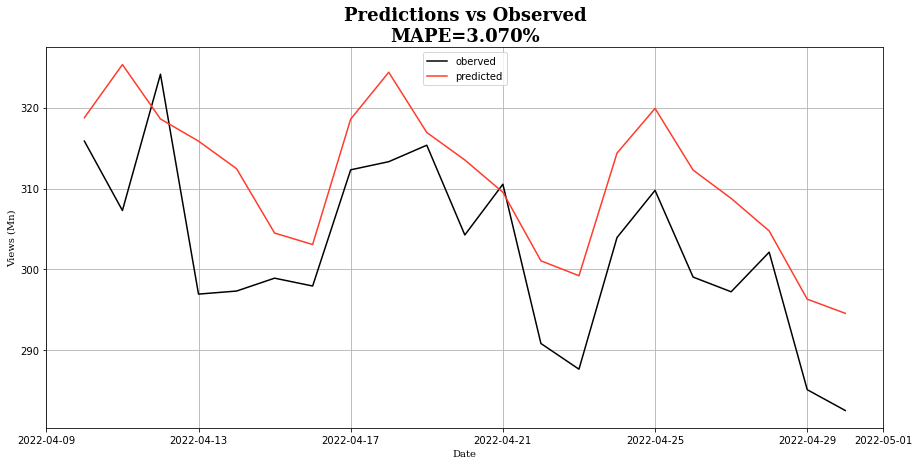

In [156]:
plot_predictions(test,predictions)